In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Lecture 17: Hypothesis Testing Pt. III

## Warm up

Suppose that we find a coin on the sidewalk and want to decide if it's fair (i.e., a 50-50 chance of landing heads or tails). 

### Step 1: Choose the Null Hypothesis

**Null Hypothesis:**

In [ ]:
# Coin lands on heads with probability 50% and tails with probability 50%
# Specific distribution of outcomes predicted for coin flips

What is the reasonable alternative hypothesis? I.e., what is the viewpoint opposing the null hypothesis?

In [ ]:
# Coin is biased
# Coin could be more likely to land on heads or more likely to land on tails

### Step 2: Gather Data

To test the null hypothesis, suppose that we flip the coin 100 times and find that it lands on heads 58% of the time.

### Step 3: Choose a Test Statistic

We want to find a test statistic where larger values make is lean more and more toward the alternative hypothesis (and away from the null). What would be a good test statistic for our null hypothesis?

In [ ]:
# frac_heads : fraction of coin flips landing on heads
# We expect that frac_heads will be close to 0.5 if null is true
# Use the statistic abs(frac_heads - 0.5)
# if this large: we know that frac_heads is either much more or much less than 0.5, indicating bias

What is the observed value of this test statistic, based on the data provided in Step 2?

In [2]:
test_stat_observed = abs(0.58 - 0.5)
test_stat_observed

0.07999999999999996

### Step 4: Find the Distribution of the Test Statistic Under the Null Hypothesis

To see if our null hypothesis is reasonable given the data from Step 2, we need to see where `test_stat_observed` is in comparison to the distribution predicted by the null hypothesis. In order to approximate this distribution, we need to repeatedly simulate the outcome of 100 coin flips as if the null hypothesis were true.

**Question:** write a function called `simulate_coin_flips` that takes no arguments. The function should simulate 100 fair coin flips (50% chance heads, 50% chance tails), and return what *fraction* of these coin flips landed on heads.

In [7]:
sample_proportions(100, make_array(0.5, 0.5))

array([ 0.46,  0.54])

In [8]:
def simulate_coin_flips():
    simulated_proportions = sample_proportions(100, make_array(0.5, 0.5))
    return simulated_proportions.item(0)

In [11]:
simulate_coin_flips()

0.54

We will now use the `simulate_coin_flips` function to sample the distribution of the test statistic:

In [12]:
coin_test_stats = make_array()
for i in range(10000):
    
    # Simulate the fraction of heads / tails out of 100 fair coin flips 
    frac_heads = simulate_coin_flips()
    
    # Compute the test statistic and append it to the coin_test_stats array
    simulated_test_stat = abs(frac_heads - 0.5)
    coin_test_stats = np.append(coin_test_stats, simulated_test_stat)

In [13]:
coin_test_stats

array([ 0.06,  0.  ,  0.04, ...,  0.04,  0.06,  0.08])

### Step 5: Compare the Observed Test Statistic to the Distribution

We now use the sample `coin_test_stats` to approximate the distribution of the test statistic under the null hypothesis.

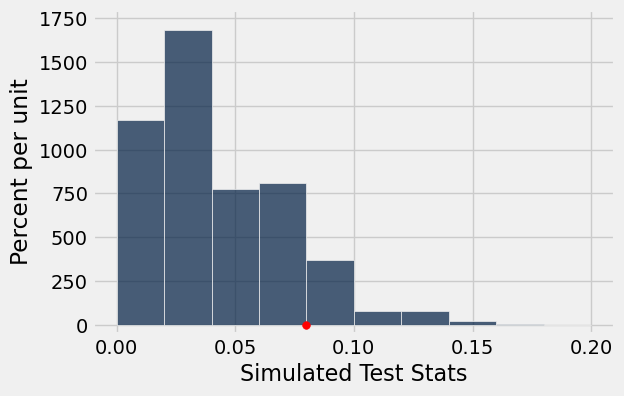

In [14]:
# Plot a histogram of the test statistic distribution
my_bins = np.arange(0, 0.22, 0.02)
Table().with_column('Simulated Test Stats', coin_test_stats).hist(bins=my_bins)

# Mark the observed value on the histogram 
plots.ylim([-0.5, 18])
plots.scatter(0.08, 0, color='red', s=30);

The observed value is larger than most of the simulated outcomes, indicating that observing this data would be unlikely if the null hypothesis were true. But is it *so* unlikely that we have disproven the null hypothesis, demonstrating that the coin is biased?

**Question:** using the `coin_test_stats` array, calculate what fraction of the test statistics simulated under the null hypothesis are *at least as large* as the observed value of 0.08.

In [18]:
sum(coin_test_stats >= 0.08) / 10000

0.1111

**Question:** if the null hypothesis is true, and we flip the coin 100 times and compute the observed test statistic, approximately what is the probability that its value is at least 0.08?

In [ ]:
# 11%

## Comparing Two Samples

We will load a dataset representing 1,174 newborn babies:

In [19]:
births = Table.read_table('data/baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In particular, we will study whether there is a link between an infant's birth weight and whether or not their mother smoked:

In [20]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [21]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


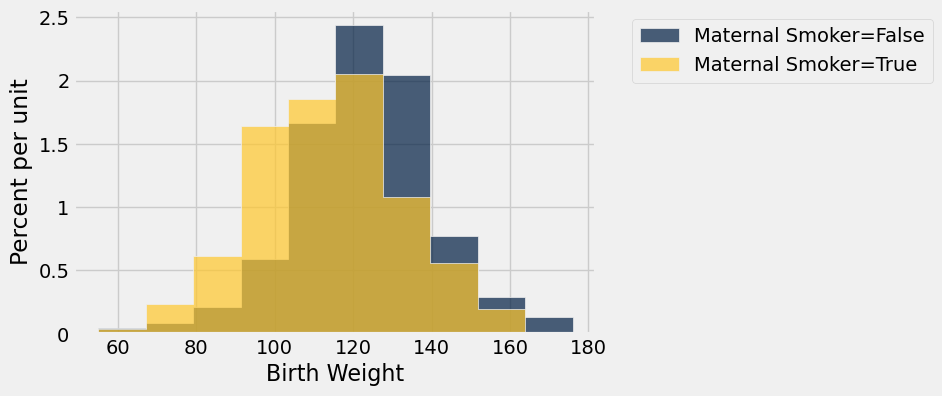

In [22]:
smoking_and_birthweight.hist('Birth Weight', group='Maternal Smoker')

In [23]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


It appears that the average birth weight in the smoker category is lower than that in the non-smoker category. *Is this difference too large to be explained by random variation*? We will have to do a hypothesis test to find out!

## Test Statistic

Our test statistic is the difference in means between each group.

First, we will calculate the observed value of the test statistic from our actual dataset:

In [24]:
observed_difference = means_table.column(1).item(1) - means_table.column(1).item(0)
observed_difference

-9.266142572024918

Since we will need to calculate differences in means quite often during A/B testing, it will be convenient to write a function to do it for us.

In [25]:
def difference_of_means(table, label, group_label):
    """
    Calculates the difference in means between two groups of rows in a table.
    Takes a table, the name of a column representing a numerical variable,
    and the name of a column indicating which group each row belongs to.
    """
    
    # table with the two relevant columns
    reduced = table.select(label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [26]:
# Test the function to see if it correctly computes the value of observed_difference
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

## Random Permutation (Shuffling)

We can randomly shuffle the rows of a table using the `sample` method. Let's look at the different ways that we can use this method, depending on the arguments that we supply.

In [27]:
letters = Table().with_column('Letter', make_array('a', 'b', 'c', 'd', 'e'))
letters

Letter
a
b
c
d
e


**Option 1**: randomly select the *original number of rows*, but with replacement (so that some rows can be repeated):

In [28]:
letters.sample()

Letter
c
c
e
e
c


**Option 2**: randomly select the *original number of rows*, but without replacement (so that no rows are repeated). In other words, randomly shuffle the order in which rows appear in the table:

In [29]:
letters.sample(with_replacement = False)

Letter
a
e
c
d
b


## Simulation Under Null Hypothesis

Let's look at our original table of data once again:

In [30]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


To simulate the null hypothesis, we want to randomly shuffle the group labels (i.e., the values in the `Maternal Smoker` column).

**Question:** create an array called `shuffled_labels`, containing a random permutation of the values in the `Maternal Smoker` column.

In [32]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement=False).column('Maternal Smoker')
shuffled_labels

array([False,  True,  True, ..., False, False, False], dtype=bool)

In [33]:
# Add the shuffled labels back to the original table
original_and_shuffled = smoking_and_birthweight.with_column(
    'Shuffled Label', shuffled_labels
)

original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,False
False,113,True
True,128,True
True,108,True
False,136,False
False,138,True
False,132,False
False,120,False
True,143,False
False,140,False


Now we can use the `difference_of_means` function to calculate the difference in means between these randomly assigned groups:

In [34]:
# Difference of means between the randomly-assigned Group A and Group B
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')

-0.13699894876364738

This is one sample of our test statistic (the difference in means) under the null hypothesis. To approximate the distribution of the test statistic, we will have to repeat this process many times: randomly re-assign rows to Group A and Group B, then calculate the difference in means.

In [35]:
differences = make_array()

for i in np.arange(1000):
    
    # Shuffle the group labels
    shuffled_labels = smoking_and_birthweight.sample(with_replacement = False).column('Maternal Smoker')
    
    # Add the shuffled labels as a new column in the table
    shuffled_table = smoking_and_birthweight.with_column(
        'Shuffled Label', shuffled_labels)
    
    # Calculate the simulated test statistic (the difference in means)
    difference = difference_of_means(shuffled_table, 'Birth Weight', 'Shuffled Label')
    differences = np.append(differences, difference)

Now we evaluate the null hypothesis by plotting a histogram of the test statistic under the null hypothesis:

Observed Difference: -9.266142572024918


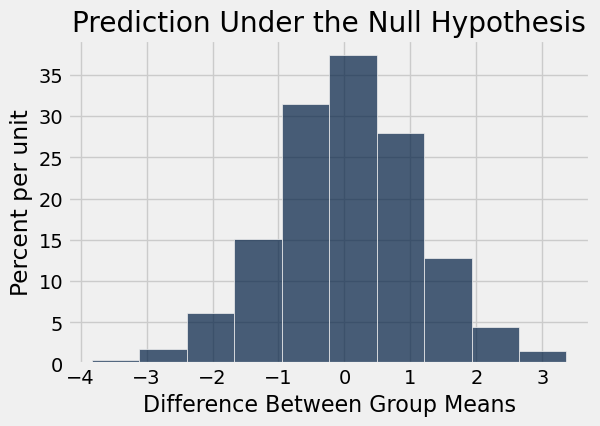

In [36]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis');

**Question:** what is the conclusion of this test?

In [ ]:
# Reject the null hypothesis!

## Example: The TA's Defense

Here are some (fictional!) midterm scores of students in a class:

In [ ]:
scores = Table.read_table('data/scores_by_section.csv')
scores

The students are divided into 12 sections:

In [ ]:
scores.group('Section').show()

**Question:** calculate the average midterm score in each section.

In [ ]:
# ...

Students in Section 3 notice that their average score is lower than other sections in the class. Is this due to random chance, or should we suspect that students in Section 3 are systematically getting lower midterm scores?

We can divide the students into two groups: Group A will consist of students in Section 3, and Group B will contain students in all of the remaining sections.

**Null hypothesis:** scores from Group A and Group B are samples from the same distribution.

**Alternative hypothesis:** distributions are not the same; in particular, Group A has a *lower* average score than Group B.

**Test statistic:** the difference in means, `np.mean(group_b) - np.mean(group_a)`. 

**Question:** do *larger* or *smaller* values of the test statistic favor the alternative hypothesis?

In [ ]:
# ...

**Question:** write a function called `difference_of_means_section3` that calculates the value of the test statistic. The function should take a single argument, `scores_table`, which has a column `Section` and a column `Midterm` (just like the `scores` table). It should then calculate the difference in means between the midterm scores in Section 3, and midterm scores in all sections *except* Section 3.

In [ ]:
def difference_of_means_section3(scores_table):
    """
    Calculate the statistic mean(group_b) - mean(group_a), where Group A are values of Midterm
    in Section 3, and Group B are values of Midterm in all other sections.
    """
    ...

In [ ]:
# Calculate the observed value of the test statistic
observed_diff = difference_of_means_section3(scores)
observed_diff

Now we will simulate the distribution of this statistic under the null hypothesis, again by repeatedly shuffling rows between the different Section groups.

In [ ]:
# Use the sample method to randomly permute the section labels for each student
shuffled_sections = scores.sample(with_replacement = False).column('Section')
shuffled_sections

In [ ]:
# Construct a table with the original midterm scores, in which the section labels are replaced
# with the randomly assigned section labels
shuffled_table = Table().with_columns(
    'Section', shuffled_sections,  # use the randomly assigned sections...
    'Midterm', scores.column('Midterm'))  # ...and the original midterm scores
shuffled_table

In [ ]:
difference_of_means_section3(shuffled_table)

Now we will repeat this process many times, to sample the distribution of the test statistic under the null hypothesis.

In [ ]:
mean_score_differences = make_array()
for i in range(1000):
    
    # Create a table with shuffled section labels
    shuffled_sections = scores.sample(with_replacement = False).column('Section')
    shuffled_table = Table().with_columns(
        'Section', shuffled_sections, 
        'Midterm', scores.column('Midterm'))
    
    # Compute the test statistic
    mean_score_diff = difference_of_means_section3(shuffled_table)
    mean_score_differences = np.append(mean_score_differences, mean_score_diff)
    

Finally, we plot the histogram, and compare it to the observed value of the statistic:

In [ ]:
Table().with_column('Section 3 Mean - All Other Mean', mean_score_differences).hist()
plots.scatter(observed_diff, 0, color='red', s=40)
plots.ylim([-0.01, 0.31])

**Question:** calculate the $p$-value for this test. Should we reject the null hypothesis in favor of the alternative?

In [ ]:
# ...